In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls

# Llamamos a la función antes de ejecutar el script
logs_dir = 'logs/NARNN/estandar'
logs_dir_auto_pred = 'logs/NARNN/auto_predictiva'
utls.eliminar_archivos_registro(logs_dir)
utls.eliminar_archivos_registro(logs_dir_auto_pred)

In [2]:
# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba

cierre = rd.leer_archivo(DATOS).astype(float)

#Obtenemos el conjunto de entrenamiento
c_entrenamiento = np.array(cierre[:int(len(cierre) * 0.7)])

#Se convierte en un arreglo bidimensional
c_entrenamiento = np.reshape(c_entrenamiento, (c_entrenamiento.shape[0], 1))

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Se normalizan los datos en un rango de 0 a 1
m_m_s = MinMaxScaler(feature_range=(0,1))
c_entrenamiento_n = m_m_s.fit_transform(c_entrenamiento)

In [4]:
#Se crean los conjuntos de entradas y salidas para la red, que funcionaran para predecir y comparar con las salidas esperadas a la hora de realizar el entrenamiento
time_steps = 8 # la cantidad de semanas anteriores a partir de las cuales se va a predecir la novena semana
N = len(c_entrenamiento_n) #182
X_entrenamiento_n = []
y_entrenamiento_n = []
for i in range(time_steps, N):
    X_entrenamiento_n.append(c_entrenamiento_n[i-time_steps:i, 0])#toma paquetes de 8 en 8
    y_entrenamiento_n.append(c_entrenamiento_n[i, 0])#se toma el elemento 8+1
X_entrenamiento_n, y_entrenamiento_n = np.array(X_entrenamiento_n), np.array(y_entrenamiento_n)

#Se le da una tercera dimension al conjunto de entradas de entrenamiento
X_entrenamiento_n = np.reshape(X_entrenamiento_n, (X_entrenamiento_n.shape[0], X_entrenamiento_n.shape[1], 1))

In [5]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.losses import mean_squared_error
from keras.models import load_model

#red = load_model('redes/DWT_LSTM/auto_predictiva/LSTM_prueba')

In [6]:
from src.modelos.auto_regresivo.NARNN.NARNN import NARNN
from keras.callbacks import TensorBoard
import src.modelos.recurrente.entrenamientos.entrenamiento as entr

red = NARNN(input_dim=8, hidden_dim=0, output_dim=1, nombre="NARNN")
red.load_state_dict(torch.load('redes/DWT_NARNN/estandar/red_' + nombre + '.pth'))
red.eval()

#red = red_GRU(input_dim = X_entrenamiento_n.shape[1],output_dim= 1)
#red = NARNN(input_dim = X_entrenamiento_n.shape[1],output_dim= 1)
red.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')# se compila la red # mejor, , SGD(learning_rate=0.1)
history = red.fit(X_entrenamiento_n,y_entrenamiento_n,epochs=60,batch_size=32,
                  callbacks=[entr.CalendarizadorPesos(logs_dir + f'/red_LSTM'), 
                                   entr.CalendarizadorPredicciones(logs_dir + f'/red_LSTM', X_entrenamiento_n, y_entrenamiento_n),
                                   TensorBoard(log_dir=logs_dir + f'/red_LSTM', histogram_freq=1)])
# Guardar el modelo entrenado
# red.save('models/LSTM.h5')


Epoch 1/60
6/6 [==============================] - 8s 360ms/step - loss: 0.5079
Epoch 2/60
6/6 [==============================] - 0s 79ms/step - loss: 0.4873
Epoch 3/60
6/6 [==============================] - 0s 85ms/step - loss: 0.4666
Epoch 4/60
6/6 [==============================] - 0s 80ms/step - loss: 0.4444
Epoch 5/60
6/6 [==============================] - 0s 77ms/step - loss: 0.4228
Epoch 6/60
6/6 [==============================] - 0s 82ms/step - loss: 0.3951
Epoch 7/60
6/6 [==============================] - 0s 81ms/step - loss: 0.3672
Epoch 8/60
6/6 [==============================] - 0s 79ms/step - loss: 0.3358
Epoch 9/60
6/6 [==============================] - 0s 77ms/step - loss: 0.3012
Epoch 10/60
6/6 [==============================] - 0s 80ms/step - loss: 0.2594
Epoch 11/60
6/6 [==============================] - 0s 76ms/step - loss: 0.2091
Epoch 12/60
6/6 [==============================] - 0s 79ms/step - loss: 0.1601
Epoch 13/60
6/6 [==============================] - 0s 79ms/s

In [7]:
precios_reales = cierre[int(len(cierre) * 0.7):] #verdaderos valores del conjunto de prueba
precios_reales = np.reshape(precios_reales, (precios_reales.shape[0], 1)) #se le da una dimension mas

In [8]:
# Se crea el conjunto de prueba
#toma los ultimos 86 elementos, los ultimos 8 de entrenamiento y todos los de prueba  
c_prueba = cierre[len(cierre) - len(precios_reales) - time_steps:]

c_prueba = np.array(c_prueba).reshape(-1,1) #(86,1)

# se normalizan los datos usandlo los parametros que se le dieron a m_m_s
m_m_s_prueba = MinMaxScaler(feature_range=(0,1))
c_prueba_n = m_m_s_prueba.fit_transform(c_prueba)

X_prueba_n = []
for i in range(time_steps, len(c_prueba_n)):
    X_prueba_n.append(c_prueba_n[i-time_steps:i, 0]) # se toman en paquetes de 8 
X_prueba_n = np.array(X_prueba_n)
X_prueba_n = np.reshape(X_prueba_n, (X_prueba_n.shape[0], X_prueba_n.shape[1], 1))#(78, 8, 1)

precios_predichos = red.predict(X_prueba_n)

#Se desnormalizan los datos
precios_predichos = m_m_s_prueba.inverse_transform(precios_predichos)

3/3 [==============================] - 0s 6ms/step


# Predicción del conjunto de prueba

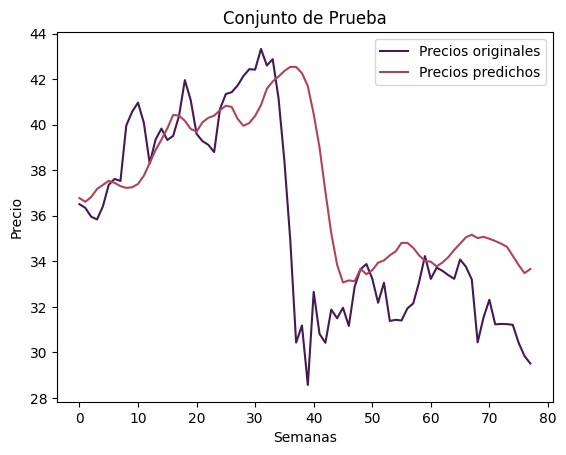

Perdida: 12.494069702166811


In [9]:
plt.plot(precios_reales, color = '#451952', label = 'Precios originales')
plt.plot(precios_predichos, color='#AE445A', label = 'Precios predichos')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
plt.legend()
plt.show()
print(f"Perdida: {mean_squared_error(np.reshape(precios_predichos, (precios_predichos.shape[0])), np.reshape(precios_reales, (precios_reales.shape[0])))}")

# Evaluación de desempeño

In [10]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(precios_reales,precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(precios_reales,precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(precios_reales,precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                          RMSE    MAPE       DS
Precicción de c_prueba  3.5347  7.0722  42.3077


In [11]:
# Definimos el número de epocas
EPOCAS = 30

In [12]:
# red = load_model('redes/DWT_LSTM/auto_predictiva/LSTM_ap_SGD_lr0.01_e10_bs1_df05.h5')

import src.modelos.recurrente.entrenamientos.entrenamiento as entrena_lstm
entrena_lstm.entrena(red,c_entrenamiento_n,y_entrenamiento_n,8,epocas= EPOCAS, lr=0.00001, t_lote = 1,
                     callbacks=[entr.CalendarizadorTasaAprendizaje(log_dir=logs_dir_auto_pred+ f'/red_LSTM',initial_lr=0.00001, decay_factor=0,red = red),
                                        entr.CalendarizadorPesos(log_dir=logs_dir_auto_pred+ f'/red_LSTM',e_predictivo=True,genera_histogramas=True,red = red)],
                                        log_dir=logs_dir_auto_pred+ f'/red_LSTM', optimizador=Adam)

# red.save_weights(f'redes/LSTM/auto_predictiva/LSTM.h5')

Ejemplar x: [[0.12010849]
 [0.01975978]
 [0.        ]
 [0.01859744]
 [0.05656722]
 [0.02595893]
 [0.03448276]
 [0.04223169]] | y: 0.04610616040294452 | Predicción actual: [[0.24802819]]
Lr que voy a aplicar en el lote es 9.999999747378752e-06
loss en el callback: 0.037179067730903625, batch 1, lote_designado 1
lr: 1e-05, batch: 1
>Fin lote<
Ejemplar x: [[0.01975978]
 [0.        ]
 [0.01859744]
 [0.05656722]
 [0.02595893]
 [0.03448276]
 [0.04223169]
 [0.24802819]] | y: 0.10422316931421921 | Predicción actual: [[0.23225437]]
Lr que voy a aplicar en el lote es 9.999999747378752e-06
loss en el callback: 0.01266101561486721, batch 2, lote_designado 1
lr: 1e-05, batch: 2
>Fin lote<
Ejemplar x: [[0.        ]
 [0.01859744]
 [0.05656722]
 [0.02595893]
 [0.03448276]
 [0.04223169]
 [0.24802819]
 [0.23225437]] | y: 0.15420379697791559 | Predicción actual: [[0.23611084]]
Lr que voy a aplicar en el lote es 9.999999747378752e-06
loss en el callback: 0.00687388563528657, batch 3, lote_designado 1
lr: 

[0.12389325726463696,
 0.12413302685184611,
 0.12323438427770847,
 0.12623179922523325,
 0.12604638479775437,
 0.12475872666667186,
 0.12484375408626758,
 0.125682004703958,
 0.1263528139438373,
 0.12674657241689505,
 0.12589410494411785,
 0.12449866194134936,
 0.12634070525681043,
 0.1279924332076849,
 0.12829748170562602,
 0.12755625731091752,
 0.1315207039619848,
 0.13312295156628293,
 0.12882559586411227,
 0.12777923010741646,
 0.1315239279458558,
 0.12938529643134744,
 0.13048129882696166,
 0.13084827611584668,
 0.1362778290391154,
 0.12916345450028976,
 0.1306183549338757,
 0.13243951262175052,
 0.13117282358844592,
 0.13346561270078733]

In [13]:
# Predice el conjunto de entrenamiento usando la prediccion predictiva a partir de los primeros (usando los datos que predice)
red_ap_X_entrenamiento_n = c_entrenamiento_n[:time_steps].reshape(time_steps)
red_ap_precios_predichos_n = utls.genera_prediccion_predictiva(red_ap_X_entrenamiento_n,8,c_entrenamiento.shape[0]-time_steps,red)  # le quitamos 8 al tamaño de datos pues 
#al principio de la funcion "genera_prediccion_predictiva" concatena los primeros 8 elementos

1/1 [==============================] - 0s 20ms/step


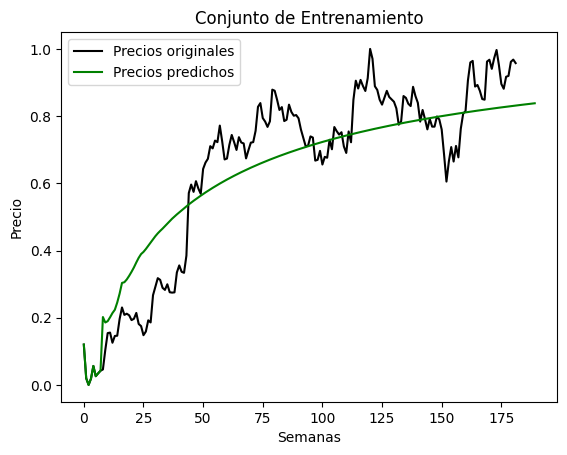

InvalidArgumentError: {{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [182] vs. [190] [Op:SquaredDifference] name: 

In [14]:
plt.plot(c_entrenamiento_n, color = 'black', label = 'Precios originales')
plt.plot(red_ap_precios_predichos_n, color = 'green', label = 'Precios predichos')
plt.title('Conjunto de Entrenamiento')
plt.xlabel('Semanas')
plt.ylabel('Precio')
plt.legend()
plt.show()
print(f"Perdida: {mean_squared_error(np.reshape(red_ap_precios_predichos_n, (red_ap_precios_predichos_n.shape[0])), np.reshape(c_entrenamiento_n, (c_entrenamiento_n.shape[0])))}")

In [17]:
# Ahora, el modelo ha sido entrenado de manera iterativa
red_ap_X_prueba_n = np.reshape(X_prueba_n[0,:], (1, X_prueba_n[0,:].shape[0], 1))
red_ap_precios_predichos = red.predict(red_ap_X_prueba_n)
f_predicted_sp_cierre = m_m_s.inverse_transform(red_ap_precios_predichos)

# Predice el conjunto de prueba usando la prediccion predictiva (ñps datos que va prediciendo)
red_ap_precios_predichos = utls.genera_prediccion_predictiva(red_ap_X_prueba_n.reshape(8),8,precios_reales.shape[0],red)
temp = red_ap_precios_predichos
red_ap_precios_predichos = m_m_s_prueba.inverse_transform(red_ap_precios_predichos.reshape(c_prueba.shape[0],1))

1/1 [==============================] - 0s 22ms/step


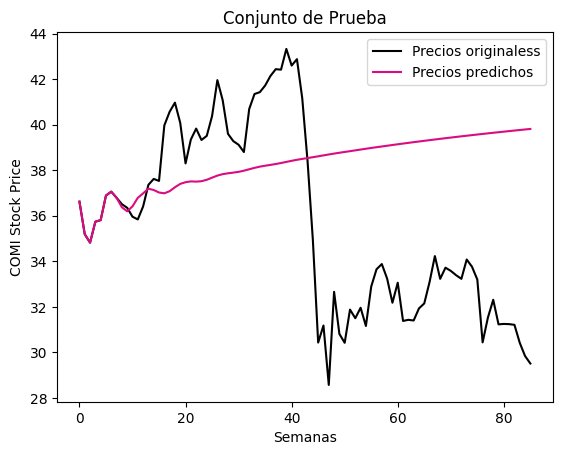

Perdida: 29.22938375194455


In [18]:
#Sin normalizar
#red_ap_precios_predichos = m_m_s_prueba.inverse_transform(c_prueba_n)
plt.plot(c_prueba, color = 'black', label = 'Precios originaless') #c_prueba_n
plt.plot(red_ap_precios_predichos, color='#DA0C81', label = 'Precios predichos')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()
print(f"Perdida: {mean_squared_error(np.reshape(red_ap_precios_predichos, (red_ap_precios_predichos.shape[0])), np.reshape(c_prueba, (c_prueba.shape[0])))}")

In [19]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(c_prueba,red_ap_precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(c_prueba,red_ap_precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(c_prueba,red_ap_precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                          RMSE     MAPE       DS
Precicción de c_prueba  5.4064  13.3522  51.1628
